In [49]:
using Plots

In [50]:
f(x) = log(x) + sin(x) / x

f (generic function with 1 method)

## Symbolic differentiation

Computing derivatives as you have seen in basic calculus courses. 

By hand (differentiation is *easy*) or automatically:
- Maple
- Sympy (python)
- Mathematica
- Maxima

Advantages:
- exact derivatives!
- gives the formula
- no hyperparameters or tweaking: just works!

Disadvantages:
- some software not flexible enough (gradients, arrays, for-loops...)
- sometimes explosion of terms: *expression swell*
- not always numerically optimal!

In [3]:
using SymEngine

In [4]:
@vars x  # define variable

(x,)

In [5]:
dfsymbolic = diff(f(x), x)

-sin(x)/x^2 + cos(x)/x + x^(-1)

In [62]:
dfsymbolic(2.0)

0.0646022250200084

## Numerical differentiation

Finite difference approximation of the derivative/gradient based on a number of function evaluations.

Often based on the limit definition of a derivative. Theoretical analysis using Taylor approximation:

$$
f(x + h) = f(x) + \frac{h}{1!} + \frac{h^2}{2!}f''(x) + \frac{h^3}{3!}f^{(3)}(x)+\ldots
$$

**Divided difference**

$$
f'(x)\approx \frac{f(x+h) - f(x)}{h}
$$


**Center difference**

$$
f'(x)\approx \frac{f(x+h) - f(x-h)}{2h}
$$


**Complex step method**

$$
f'(x)\approx \frac{Im (f(x +ih))}{h}
$$

Some simple implementation:

In [113]:
diff_divdiff(f, x; h=1e-10) = (f(x + h) - f(x)) / h
diff_centdiff(f, x; h=1e-10) = (f(x + h) - f(x - h)) / (2h)
diff_complstep(f, x; h=1e-10) = imag(f(x + im * h)) / h

diff_complstep (generic function with 1 method)

In [115]:
@time diff_divdiff(f, 2.0)

  0.000007 seconds (6 allocations: 192 bytes)


0.06460165735688861

In [116]:
@time diff_centdiff(f, 2.0)

  0.010944 seconds (23.38 k allocations: 1.284 MiB)


0.06460165735688861

In [118]:
@time diff_complstep(f, 2.0)

  0.000008 seconds (6 allocations: 192 bytes)


0.06460222502000833

In [68]:
error(diff, h; x=2.0) = max(abs(Float64(dfsymbolic(x)) - diff(f, x, h=h)), 1e-30);
stepsizes = map(t->10.0^t, -20:0.5:-1);

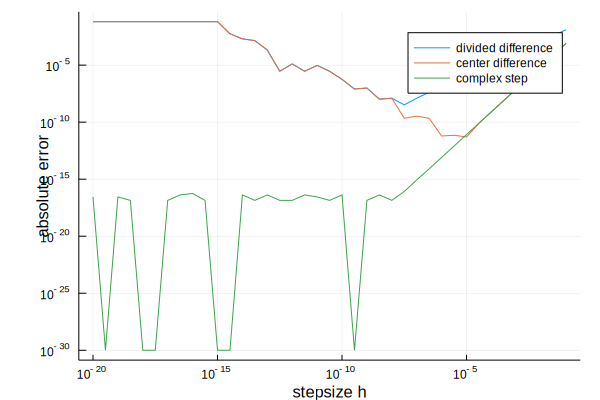

In [69]:
plot(stepsizes, error.(diff_divdiff, stepsizes), label="divided difference",
    xscale=:log10, yscale=:log10)
plot!(stepsizes, error.(diff_centdiff, stepsizes), label="center difference")
plot!(stepsizes, error.(diff_complstep, stepsizes), label="complex step")
#xlims!(1e-15, 1e-1)
xlabel!("stepsize h")
ylabel!("absolute error")

Advantages of numerical differentiation:
- easy to implement
- general, no assumption

Disadvantages:
- not numerically stable (round-off errors)
- not efficient for gradients ($n$ evaluations for $n$-dimensional vectors)

> **first sin of numerical analysis**:  *thou shalt not add small numbers to big numbers*

> **second sin of numerical analysis**: *thou shalt not subtract numbers which are approximately equal*

### Stein's lemma

$$
E_{X\sim N(\mu, \sigma)}[f(X)(X-\mu)] = \sigma^2 E_{X\sim N(\mu, \sigma)}[f'(X)]
$$

and thus

$$
E_{\epsilon\sim N(0, 1)}[f'(x + \sigma\epsilon)] = \frac{1}{\sigma} E_{\epsilon\sim N(0, 1)}[f(x+\sigma \epsilon)\epsilon]
$$

In [111]:
diff_stein(f, x; σ=1e-1, n=10_000) = 1 / σ * sum(map(e -> f(x + σ * e) * e, randn(n))) / n

diff_stein (generic function with 1 method)

In [112]:
@time diff_stein(f, 2.0)

  0.056700 seconds (86.08 k allocations: 4.573 MiB, 17.99% gc time)


0.2163212662488675

**Gradient-vector approximation**

$$
\nabla f(\mathbf{x})^\intercal \mathbf{d} \approx \frac{f(\mathbf{x}+h\cdot\mathbf{d}) - f(\mathbf{x}-h\cdot\mathbf{d})}{2h}
$$

**Hessian-vector approximation**

$$
\nabla^2 f(\mathbf{x}) \mathbf{d} \approx \frac{\nabla f(\mathbf{x}+h\cdot\mathbf{d}) - \nabla f(\mathbf{x}-h\cdot\mathbf{d})}{2h}
$$

In [70]:
grad_vect(f, x, d; h=1e-10) = (f(x + h * d) - f(x - h * d)) / (2h)

grad_vect (generic function with 1 method)

In [15]:
dvect = randn(10) / 10
xvect = 2rand(10)

A = randn(10, 10)
A = A * A' / 100

#g(x) = exp(- x' * A * x)  # adjoint does not play with Zygote
g(x) = exp(- sum(x .* (A * x)))

∇g(x) = -2g(x) * A * x
∇²g(x) = -2g(x) * A - 2A * x * ∇g(x)'

∇²g (generic function with 1 method)

In [16]:
g(xvect)

0.514517920521928

In [17]:
∇g(xvect)

10-element Array{Float64,1}:
 -0.040671876827038836
 -0.147303100818978   
  0.039998306052443505
 -0.09268111077264779 
 -0.10664827930038674 
 -0.0378239318651612  
 -0.04088977957306074 
 -0.07814799799297588 
  0.15363039540174964 
  0.059653778038757814

In [18]:
∇g(xvect)' * dvect

0.04068968018740373

In [19]:
grad_vect(g, xvect, dvect)

0.04068967385251199

In [22]:
∇²g(xvect) * dvect

10-element Array{Float64,1}:
  0.0007003810249027499
 -0.006124263494043334 
 -0.004152137233151294 
  0.023862623438686954 
  0.005193172678846626 
 -0.016410871105513154 
 -0.01681037697050671  
 -0.006090260885826185 
  0.0019820944741174126
 -0.0060378399384015185

In [23]:
h = 1e-10
(∇g(xvect + h * dvect) - ∇g(xvect - h * dvect)) / (2h)

10-element Array{Float64,1}:
  0.0007003425617213566
 -0.00612426775958852  
 -0.004152164723159046 
  0.02386264796871984  
  0.005193137586623209 
 -0.01641086572190531  
 -0.016810441927361808 
 -0.006090128401581296 
  0.001982164432590139 
 -0.006037809141545836 

## Forward differentiation

Accumulation of the gradients along the *computational graph*.

==add graph==

Forward differentiation can be viewed as evaluating function using *dual numbers*, which can be viewed as truncated Taylor series:

$$
v + \dot{v}\epsilon\,,
$$

where $v,\dot{v}\in\mathbb{R}$ and $\epsilon$ a nilpotent number, i.e. $\epsilon^2=0$. For example, we have

$$
(v + \dot{v}\epsilon) + (u + \dot{u}\epsilon) = (v+u) + (\dot{v} +\dot{u})\epsilon
$$


$$
(v + \dot{v}\epsilon)(u + \dot{u}\epsilon) = (vu) + (v\dot{u} +\dot{v}u)\epsilon\,.
$$



These number can be used as

$$
f(v+\dot{v}) = f(v) + f'(v)\dot{v}\epsilon\,.
$$

In [119]:
struct Dual
    v
    v̇
end

ErrorException: invalid redefinition of constant Dual

In [120]:
Base.:+(a::Dual, b::Dual) = Dual(a.v + b.v, a.v̇ + b.v̇)
Base.:*(a::Dual, b::Dual) = Dual(a.v * b.v, a.v * b.v̇ + b.v * a.v̇)
Base.:sin(a::Dual) = Dual(sin(a.v), cos(a.v) * a.v̇)
Base.:log(a::Dual) = Dual(log(a.v), 1.0 / a.v * a.v̇)
Base.:/(a::Dual, b::Dual) = Dual(a.v / b.v, (a.v̇ * b.v - a.v * b.v̇) / b.v^2)

In [47]:
f(Dual(2.0, 1.0))

Dual(1.1477958939727861, 0.06460222502000834)

In [26]:
using ForwardDiff

In [27]:
ForwardDiff.derivative(f, 2.0)

0.06460222502000834

In [28]:
ForwardDiff.gradient(g, xvect)

10-element Array{Float64,1}:
 -0.04067187682703883 
 -0.14730310081897802 
  0.039998306052443505
 -0.09268111077264782 
 -0.10664827930038676 
 -0.03782393186516119 
 -0.040889779573060725
 -0.07814799799297588 
  0.1536303954017496  
  0.05965377803875778 

## Reverse differentiation

In [29]:
using Zygote

In [30]:
f'(2.0)

0.06460222502000834

In [31]:
g'(xvect)

10-element Array{Float64,1}:
 -0.040671876827038836
 -0.147303100818978   
  0.039998306052443505
 -0.09268111077264783 
 -0.10664827930038674 
 -0.03782393186516119 
 -0.04088977957306073 
 -0.07814799799297589 
  0.1536303954017496  
  0.05965377803875778 

In [32]:
xvect

10-element Array{Float64,1}:
 0.9461378418920856 
 1.7894229138332634 
 0.5783547737820731 
 1.403805901993879  
 1.0144055191518673 
 0.701669776557619  
 0.8288415963246187 
 1.925083474284222  
 0.12527783599907538
 0.4196296046975343 